In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras import backend as K

In [2]:

import zipfile
import os
import tensorflow as tf


zip_files = [
    '/content/Potato___Early_blight.zip',
    '/content/Potato___Late_blight.zip',
    '/content/Potato___healthy.zip'
]


main_directory = '/content/PlantVillage/'
os.makedirs(main_directory, exist_ok=True)

for zip_file in zip_files:

    extract_to = os.path.join(main_directory, os.path.splitext(os.path.basename(zip_file))[0])
    # Extract the .zip file to the directory
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Use the parent directory for the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=main_directory,  # Path to the main directory containing class subdirectories
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical'
)


for images, labels in dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Found 2152 files belonging to 3 classes.
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 3)


In [3]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
len(dataset)


68

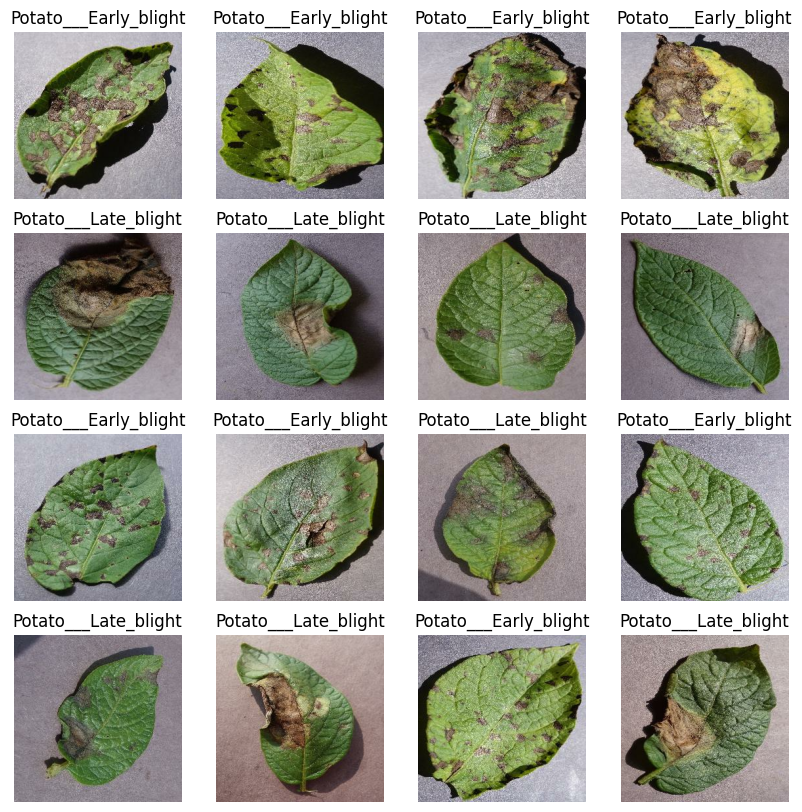

In [5]:
plt.figure(figsize=(10,10))
for images, labels in dataset.take(1):
   for i in range(16):
      ax = plt.subplot(4,4,i+1)

      plt.imshow(images[i].numpy().astype("uint8"))
      plt.axis("off")
      plt.title(class_name[tf.argmax(labels[i])])
plt.show()
    # print(images[31].numpy())

In [6]:
len(dataset)

68

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
rem = dataset.skip(54)
len(rem)

14

In [10]:
valid_ds = rem.take(7)
len(valid_ds)

7

In [11]:
test_ds = rem.skip(7)
len(test_ds)

7

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
])

In [14]:
(tf.__version__)

'2.17.0'

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255)
    ])

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
input_shape = (32, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(
    optimizer='SGD',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=valid_ds,
    verbose=1,
    epochs=30
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 272ms/step - accuracy: 0.4439 - loss: 1.0161 - val_accuracy: 0.4955 - val_loss: 0.8941
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.4903 - loss: 0.8942 - val_accuracy: 0.5402 - val_loss: 0.8884
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.5812 - loss: 0.8672 - val_accuracy: 0.4955 - val_loss: 0.8727
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.5695 - loss: 0.8562 - val_accuracy: 0.4777 - val_loss: 0.8844
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.6629 - loss: 0.8463 - val_accuracy: 0.7232 - val_loss: 0.8395
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - accuracy: 0.6807 - loss: 0.7935 - val_accuracy: 0.4955 - val_loss: 0.9425
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.6548 - loss: 0.7637 - val_accuracy: 0.6920 - val_loss: 0.7243
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.7125 - loss: 0.7286 - val_accu

In [20]:
model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8991 - loss: 0.2172


[0.2483617663383484, 0.8799999952316284]

In [21]:
history

In [22]:
a = history.history['loss']
len(a)

30

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

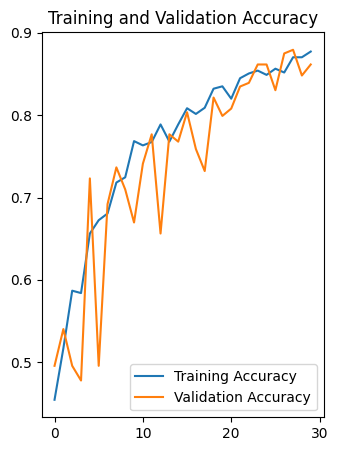

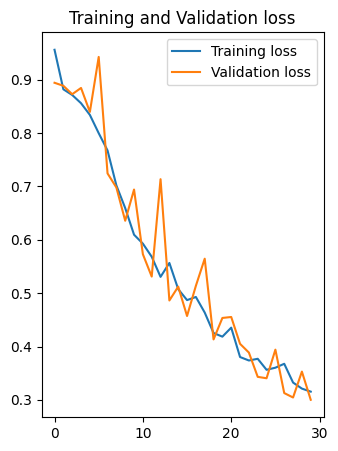

In [24]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(range(30),acc, label='Training Accuracy')
plt.plot(range(30),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(range(30),loss, label='Training loss')
plt.plot(range(30),val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')


In [31]:
model_version = 1
model.save(f"model_{model_version}.keras")





In [35]:
model_version = 1
export_path = f"model_{model_version}"

# Export the model to the specified path
model.export(export_path)






Saved artifact at 'model_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132472217875232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472217876464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472098312560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472098315552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472098313088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472098318016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472098317312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472098319776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472098319072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472098321536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132472098320832: Tens

In [36]:
import shutil

# Zip the exported model directory
shutil.make_archive(export_path, 'zip', export_path)


'/content/model_1.zip'

In [37]:
from google.colab import files

# Download the zipped model file
files.download(f"{export_path}.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>